# Channel Head Coupling Analysis

This notebook analyzes the coupling between channel heads in a drainage network derived from a DEM using **TopoToolbox (Python)**.  
We:
- Load the DEM and derive flow and stream networks.
- Identify outlets, confluences, and channel heads.
- Compute *first-meet pairs* of channel heads per confluence.
- Evaluate which pairs are *coupled* (touching).
- Visualize coupled pairs and outlet subgraphs.

---

In [ ]:
# === Setup ===
import sys, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3
import topotoolbox._stream as _stream

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports from your channel_heads package
from channel_heads.first_meet_pairs_for_outlet import first_meet_pairs_for_outlet
from channel_heads.coupling_analysis import CouplingAnalyzer
from channel_heads.stream_utils import outlet_node_ids_from_streampoi
from channel_heads.plotting_utils import (
    plot_coupled_pair,
    plot_outlet_view,
    plot_all_coupled_pairs_for_outlet,
    plot_all_coupled_pairs_for_outlet_3d
)

## 1. Load and Preprocess DEM

We load the SRTM DEM from disk and mask out low elevation values (<1200 m).  
A basic visualization helps confirm the data integrity.

name: Inyo_strm_crop
path: /Users/guypi/Projects/channel-heads/data/cropped_DEMs/Inyo_strm_crop.tif
rows: 289
cols: 284
cellsize: 0.000833333333333144
bounds: BoundingBox(left=-118.07125000001407, bottom=36.62458333333865, right=-117.83458333334747, top=36.865416666671926)
transform: | 0.00, 0.00,-118.07|
| 0.00,-0.00, 36.87|
| 0.00, 0.00, 1.00|
coordinate system (Geographic): EPSG:4326
maximum z-value: 3363.0
minimum z-value: 329.0


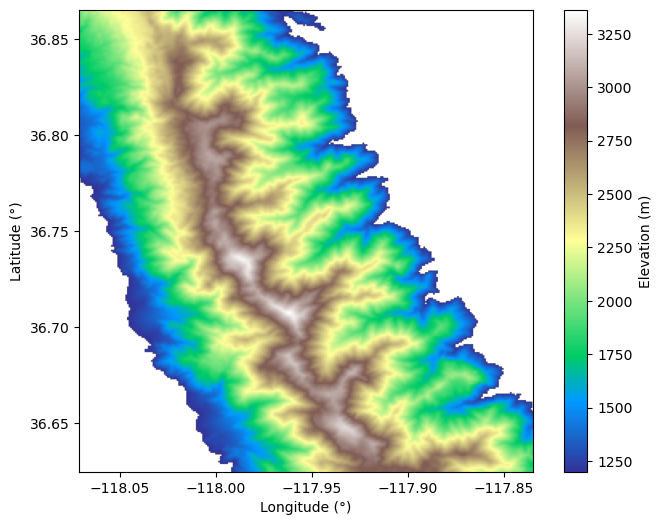

In [2]:
dem = tt3.read_tif("/Users/guypi/Projects/channel-heads/data/cropped_DEMs/Inyo_strm_crop.tif")
dem.info()

# Mask out low elevations
dem.z[dem.z < 1200] = np.nan

fig, ax = plt.subplots(figsize=(8,6))
im = dem.plot(ax=ax, cmap='terrain')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
plt.colorbar(im, ax=ax, label="Elevation (m)")

## 2. Flow and Stream Network

We derive a `FlowObject` from the DEM and create a `StreamObject` using a threshold area.

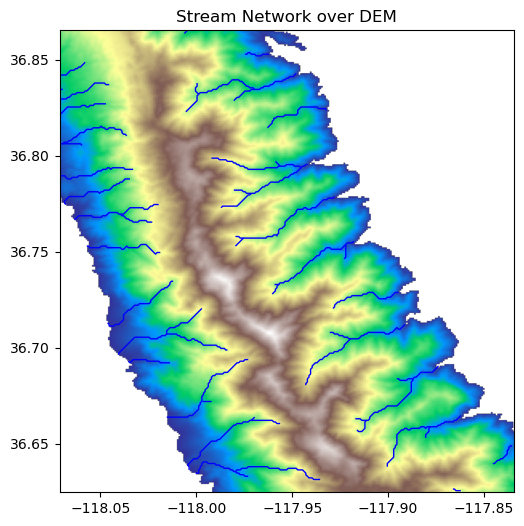

In [3]:
fd = tt3.FlowObject(dem)
s = tt3.StreamObject(fd, threshold=300)

fig, ax = plt.subplots(figsize=(8,6))
dem.plot(ax=ax, cmap='terrain')
s.plot(ax=ax, color='blue', linewidth=1)
ax.set_title("Stream Network over DEM")
plt.show()

In [4]:
outlet_mask = s.streampoi('outlets')
conf_mask   = s.streampoi('confluences')
heads_mask  = s.streampoi('channelheads')

outlet_ids = np.flatnonzero(outlet_mask)

print("POIs:")
print("  outlets:", int(outlet_mask.sum()))
print("  confluences:", int(conf_mask.sum()))
print("  channel heads:", int(heads_mask.sum()))
print("First 10 outlet node-ids:", outlet_ids[:10])

POIs:
  outlets: 28
  confluences: 19
  channel heads: 47
First 10 outlet node-ids: [  1   2   3   4   5   6  37  73 134 225]


In [5]:
by_outlet = {}

for o in outlet_ids:
    single_outlet_mask = np.zeros_like(outlet_mask, dtype=bool)
    single_outlet_mask[o] = True

    s_up_o = s.upstreamto(single_outlet_mask)
    conf_o = s_up_o.streampoi('confluences')
    conf_ids_o = np.flatnonzero(conf_o)

    heads_by_conf = {}
    for c_local in conf_ids_o:
        c_mask_local = np.zeros_like(conf_o, dtype=bool)
        c_mask_local[c_local] = True
        s_up_c = s_up_o.upstreamto(c_mask_local)
        head_ids_c = np.flatnonzero(s_up_c.streampoi('channelheads'))
        heads_by_conf[c_local] = head_ids_c

    by_outlet[o] = {
        "s_up": s_up_o,
        "confluences_local": conf_ids_o,
        "heads_by_confluence_local": heads_by_conf,
    }

# Compact print (optional)
for o, data in list(by_outlet.items())[:-1]:
    print(f"\nOutlet {o}:")
    print(f"  - Number of confluences: {len(data['confluences_local'])}")
    for c_local in data["confluences_local"]:
        heads_local = data["heads_by_confluence_local"].get(c_local, [])
        print(f"    Confluence {c_local}: {len(heads_local)} heads -> {heads_local}")


Outlet 1:
  - Number of confluences: 0

Outlet 2:
  - Number of confluences: 0

Outlet 3:
  - Number of confluences: 0

Outlet 4:
  - Number of confluences: 0

Outlet 5:
  - Number of confluences: 1
    Confluence 2: 2 heads -> [24 53]

Outlet 6:
  - Number of confluences: 0

Outlet 37:
  - Number of confluences: 0

Outlet 73:
  - Number of confluences: 1
    Confluence 29: 2 heads -> [40 44]

Outlet 134:
  - Number of confluences: 0

Outlet 225:
  - Number of confluences: 0

Outlet 271:
  - Number of confluences: 1
    Confluence 33: 2 heads -> [45 62]

Outlet 322:
  - Number of confluences: 0

Outlet 457:
  - Number of confluences: 1
    Confluence 28: 2 heads -> [21 44]

Outlet 511:
  - Number of confluences: 0

Outlet 519:
  - Number of confluences: 1
    Confluence 45: 2 heads -> [ 3 20]

Outlet 543:
  - Number of confluences: 1
    Confluence 29: 2 heads -> [16 62]

Outlet 909:
  - Number of confluences: 0

Outlet 1050:
  - Number of confluences: 2
    Confluence 18: 2 heads -> 

### channel-head coupeling

In [ ]:
from channel_heads.coupling_analysis import CouplingAnalyzer
an = CouplingAnalyzer(fd, s, dem, connectivity=8)

In [7]:
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")
print("Outlet node IDs:", outs[:-1])

Found 28 outlets.
Outlet node IDs: [   1    2    3    4    5    6   37   73  134  225  271  322  457  511
  519  543  909 1050 1097 1162 1182 1240 1357 1374 1436 1456 1457]


In [8]:
# === choose outlet ===
o = outs[4]
print("Selected outlet node id:", o)

# === run the same downstream logic ===
pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)
an = CouplingAnalyzer(fd, s, dem)
df = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
df.head()

Selected outlet node id: 5


,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,5,20,110,307,True,0,21,320,307


In [9]:
def compute_coupling_all_outlets(s, fd, dem, outlets=None, warmup=True, connectivity=8):
    """
    Build a single DataFrame of coupling results for all (or selected) outlets.

    Columns:
      outlet, confluence, head_1, head_2, touching, overlap_px, contact_px, size1_px, size2_px
    """
    # 0) pick outlets
    if outlets is None:
        outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]

    # 1) analyzer (we’ll reuse it; clear its cache per outlet to bound memory)
    an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)

    dfs = []
    for idx, o in enumerate(outlets, 1):
        # print small progress breadcrumb
        print(f"[{idx}/{len(outlets)}] outlet={o}", flush=True)

        # 2) first-meet pairs for this outlet
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, o)

        # 3) optional warm-up: precompute masks for heads in this basin
        if warmup and basin_heads:
            an._mask_cache.clear()          # keep cache limited per outlet
            # touch each head once to populate cache
            for h in basin_heads:
                _ = an.influence_mask(int(h))

        # 4) evaluate pairs → per-outlet DataFrame
        df_o = an.evaluate_pairs_for_outlet(o, pairs_at_confluence)
        if not df_o.empty:
            dfs.append(df_o)

    # 5) concat
    if not dfs:
        cols = ["outlet","confluence","head_1","head_2","touching","overlap_px","contact_px","size1_px","size2_px"]
        return pd.DataFrame(columns=cols)

    df_all = pd.concat(dfs, ignore_index=True)
    # nice ordering
    df_all.sort_values(["outlet","confluence","head_1","head_2"], inplace=True, ignore_index=True)
    return df_all

In [10]:
# All outlets
outs = outlet_node_ids_from_streampoi(s)
print("Found", len(outs), "outlets.")

df_all = compute_coupling_all_outlets(s, fd, dem, outlets=outs, warmup=True, connectivity=8)

print("Total pairs evaluated:", len(df_all))
print("Overall touching rate:", df_all["touching"].mean() if not df_all.empty else 0.0)
df_all.head()

Found 28 outlets.
[1/28] outlet=1
[2/28] outlet=2
[3/28] outlet=3
[4/28] outlet=4
[5/28] outlet=5
[6/28] outlet=6
[7/28] outlet=37
[8/28] outlet=73
[9/28] outlet=134
[10/28] outlet=225
[11/28] outlet=271
[12/28] outlet=322
[13/28] outlet=457
[14/28] outlet=511
[15/28] outlet=519
[16/28] outlet=543
[17/28] outlet=909
[18/28] outlet=1050
[19/28] outlet=1097
[20/28] outlet=1162
[21/28] outlet=1182
[22/28] outlet=1240
[23/28] outlet=1357
[24/28] outlet=1374
[25/28] outlet=1436
[26/28] outlet=1456
[27/28] outlet=1457
[28/28] outlet=1473
Total pairs evaluated: 26
Overall touching rate: 0.34615384615384615


,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,5,20,110,307,True,0,21,320,307
1,73,275,413,434,True,0,39,303,310
2,271,455,578,691,False,0,0,383,320
3,457,583,627,814,False,0,0,304,322
4,519,833,849,983,False,0,0,301,305


In [11]:
df_touching = df_all[df_all["touching"] == True].copy()
print("Touching pairs:", len(df_touching))

Touching pairs: 9


In [12]:
df_touching.sort_values(
    ["outlet", "confluence", "head_1", "head_2"],
    inplace=True,
    ignore_index=True
)
df_touching.head(20)

,outlet,confluence,head_1,head_2,touching,overlap_px,contact_px,size1_px,size2_px
0,5,20,110,307,True,0,21,320,307
1,73,275,413,434,True,0,39,303,310
2,1097,831,662,716,True,0,42,305,318
3,1097,979,623,945,True,0,6,360,327
4,1097,1073,623,716,True,0,24,360,318
5,1182,780,726,727,True,0,63,307,430
6,1182,959,727,960,True,0,29,430,304
7,1240,974,930,939,True,0,78,620,302
8,1436,1276,1245,1249,True,0,71,409,302


In [13]:
summary_touch = (
    df_touching.groupby("outlet")
               .size()
               .reset_index(name="n_touching_pairs")
               .sort_values("n_touching_pairs", ascending=False)
)
summary_touch.head(10)

,outlet,n_touching_pairs
2,1097,3
3,1182,2
0,5,1
1,73,1
4,1240,1
5,1436,1


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Outlet 1097 — 3 coupled pairs (crop)'}>)

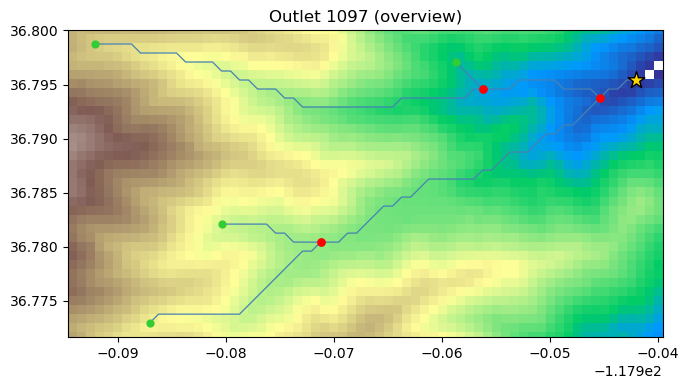

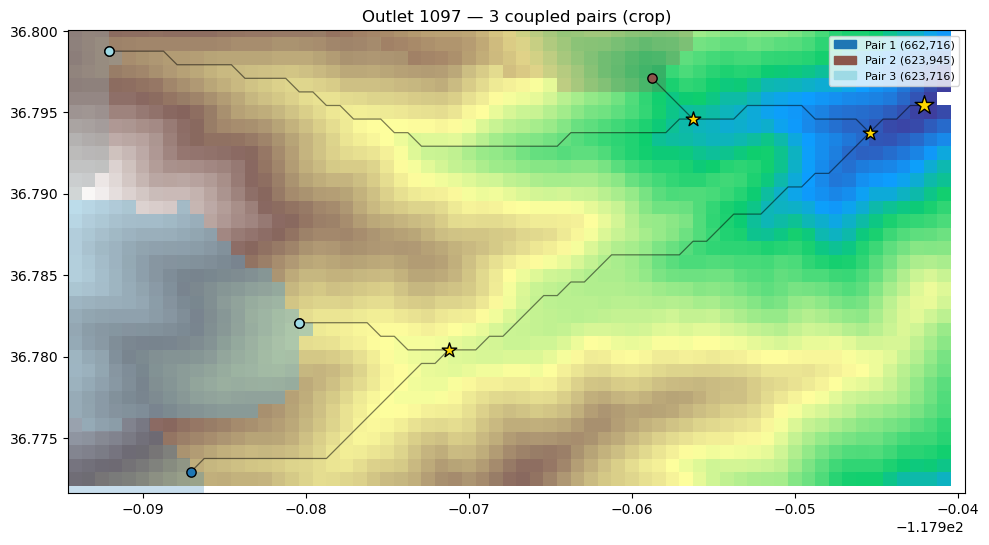

In [14]:
plot_outlet_view(s, 1097, dem, view_mode="overview")



# overview of all pairs still needs 'an'
plot_all_coupled_pairs_for_outlet(fd, s, dem, an, df_touching, 1097, view_mode="crop")